In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import re
import warnings

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
import pickle

In [2]:
warnings.filterwarnings(action="ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 1.0. Data Reading and Cleaning

In [3]:
dataset = './data/tabela-fipe-historico-precos.csv'
df_raw = pd.read_csv(dataset)

In [4]:
df_raw.head()

,Unnamed: 0,codigoFipe,marca,modelo,anoModelo,mesReferencia,anoReferencia,valor
0,0,038003-2,Acura,Integra GS 1.8,1992,11,2016,13041.0
1,1,038001-6,Acura,NSX 3.0,1995,3,2013,52339.0
2,2,038003-2,Acura,Integra GS 1.8,1992,3,2018,12423.0
3,3,038002-4,Acura,Legend 3.2/3.5,1998,5,2016,31067.0
4,4,038002-4,Acura,Legend 3.2/3.5,1998,2,2019,26381.0


In [5]:
df_raw.shape

(466020, 8)

In [6]:
df_raw.columns

Index(['Unnamed: 0', 'codigoFipe', 'marca', 'modelo', 'anoModelo',
       'mesReferencia', 'anoReferencia', 'valor'],
      dtype='object')

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466020 entries, 0 to 466019
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     466020 non-null  int64  
 1   codigoFipe     466020 non-null  object 
 2   marca          466020 non-null  object 
 3   modelo         466020 non-null  object 
 4   anoModelo      466020 non-null  int64  
 5   mesReferencia  466020 non-null  int64  
 6   anoReferencia  466020 non-null  int64  
 7   valor          466020 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 28.4+ MB


<Axes: ylabel='Frequency'>

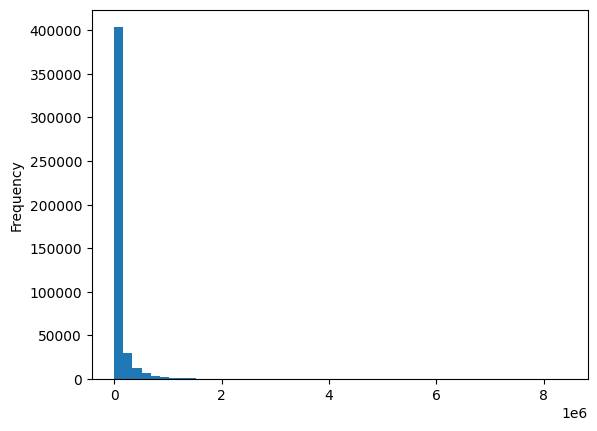

In [8]:
df_raw['valor'].plot(kind='hist', bins = 50)

## 1.1. Data Cleaning

In [9]:
df1 = df_raw.copy()
df1.shape

(466020, 8)

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466020 entries, 0 to 466019
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     466020 non-null  int64  
 1   codigoFipe     466020 non-null  object 
 2   marca          466020 non-null  object 
 3   modelo         466020 non-null  object 
 4   anoModelo      466020 non-null  int64  
 5   mesReferencia  466020 non-null  int64  
 6   anoReferencia  466020 non-null  int64  
 7   valor          466020 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 28.4+ MB


In [11]:
def snake_case(c):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', c).lower()
df1.columns = [snake_case(c) for c in df1.columns]

categorical_columns = list(df1.dtypes[df1.dtypes == 'object'].index)
for c in categorical_columns:
    df1[c] = df1[c].str.lower().str.replace(' ', '_')
    df1[c] = df1[c].str.replace('-','_')

df1['codigo_fipe'] = df1['codigo_fipe'].str.replace('-','')

In [12]:
# couldn't figure out how to not import this column while reading the dataset
df1.drop(columns=['unnamed: 0'], inplace=True)

### 1.1.1. Checking Data Types

In [13]:
df1.dtypes

codigo_fipe        object
marca              object
modelo             object
ano_modelo          int64
mes_referencia      int64
ano_referencia      int64
valor             float64
dtype: object

In [14]:
df1['codigo_fipe'] = df1['codigo_fipe'].astype('int64')

In [15]:
df1.dtypes

codigo_fipe         int64
marca              object
modelo             object
ano_modelo          int64
mes_referencia      int64
ano_referencia      int64
valor             float64
dtype: object

### 1.1.2. Checking for Missing Values

In [16]:
df1.isna().sum()

codigo_fipe       0
marca             0
modelo            0
ano_modelo        0
mes_referencia    0
ano_referencia    0
valor             0
dtype: int64

### 1.1.3. Checking for Duplicated Values

In [17]:
df1.duplicated().sum()

0

# 2.0. Feature Engineering

In [18]:
df2 = df1.copy()

In [19]:
media_por_marca = df2.groupby('marca')['valor'].mean()

df2['classificacao_marca'] = df2['marca'].map(
        lambda marca: (
        'economical' if media_por_marca[marca] <= 50_000 else
        'affordable' if media_por_marca[marca] <= 100_000 else
        'mid_range' if media_por_marca[marca] <= 500_000 else
        'luxury' if media_por_marca[marca] <= 1_000_000 else
        'super_luxury' if media_por_marca[marca] <= 5_000_000 else
        'ultra_luxury'
    )
)



## 2.2. Spliting Data

In [20]:
df_full_train, df_test = train_test_split(df2, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [21]:
len(df_train), len(df_val), len(df_test)

(279612, 93204, 93204)

In [22]:
X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

In [23]:
y_train = X_train.valor.values
y_val = X_val.valor.values
y_test = X_test.valor.values

In [24]:
X_train.drop(columns=['valor'], inplace=True)
X_val.drop(columns=['valor'], inplace=True)
X_test.drop(columns=['valor'], inplace=True)

# 3.0. Feature Selection

In [25]:
freq_encoding_map = X_train['marca'].value_counts() / len(X_train)
X_train['marca_freq_encoded'] = X_train['marca'].map(freq_encoding_map)
X_val['marca_freq_encoded'] = X_val['marca'].map(freq_encoding_map)
X_test['marca_freq_encoded'] = X_test['marca'].map(freq_encoding_map)

X_train = pd.get_dummies(X_train, columns=['classificacao_marca'], drop_first=True)
X_val = pd.get_dummies(X_val, columns=['classificacao_marca'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['classificacao_marca'], drop_first=True)

X_train.drop(columns=['marca', 'modelo'], inplace=True) 
X_val.drop(columns=['marca', 'modelo'], inplace=True) 
X_test.drop(columns=['marca', 'modelo'], inplace=True)

In [26]:
categorical_cols = ['marca_freq_encoded'] + [col for col in X_train.columns if col.startswith('classificacao_marca')]
numerical_cols = ['codigo_fipe', 'ano_modelo', 'ano_referencia', 'mes_referencia']

# 5.0. Training Models

In [27]:
def ml_error_to_df(model_name, model, X, y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())  # turning neg mse into rmse

    result_df = pd.DataFrame({
        "Model Name": [model_name],
        "MAE": [mae],
        "MAPE": [mape],
        "RMSE": [rmse],
        "CV RMSE": [cv_rmse]
    })

    return result_df


## 5.1. Ensemble Learning Models

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', 'passthrough', categorical_cols)
    ]
)

### 5.1.1. Random Forest

In [32]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500,
                                        min_samples_leaf=1,
                                        min_samples_split=2,
                                        random_state=42))
])

pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['codigo_fipe', 'ano_modelo',
                                                   'ano_referencia',
                                                   'mes_referencia']),
                                                 ('cat', 'passthrough',
                                                  ['marca_freq_encoded',
                                                   'classificacao_marca_economical',
                                                   'classificacao_marca_luxury',
                                                   'classificacao_marca_mid_range',
                                                   'classificacao_marca_super_luxury'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=500, random_state=42))])

In [33]:
y_pred_rf = pipeline_rf.predict(X_test)

In [34]:
error_rf = ml_error_to_df("Random Forest", pipeline_rf, X_test, y_test, y_pred_rf)
error_rf

,Model Name,MAE,MAPE,RMSE,CV RMSE
0,Random Forest,2349.697987,0.01677,18642.668115,55531.584715


### 5.1.2. LightGBM

In [29]:
pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42, metric='rmse', force_row_wise=True))
])

In [30]:
pipeline_lgb.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 279612, number of used features: 9
[LightGBM] [Info] Start training from score 116098.476031


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['codigo_fipe', 'ano_modelo',
                                                   'ano_referencia',
                                                   'mes_referencia']),
                                                 ('cat', 'passthrough',
                                                  ['marca_freq_encoded',
                                                   'classificacao_marca_economical',
                                                   'classificacao_marca_luxury',
                                                   'classificacao_marca_mid_range',
                                                   'classificacao_marca_super_luxury'])])),
                ('regressor',
                 LGBMRegressor(force_row_wise=True, metric='rmse',
                               random_state=42))])

In [31]:
y_pred_lgb = pipeline_lgb.predict(X_test)

In [32]:
error_lgb = ml_error_to_df("LightGBM", pipeline_lgb, X_test, y_test, y_pred_lgb)
error_lgb

[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 74563, number of used features: 9
[LightGBM] [Info] Start training from score 116044.950445
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 74563, number of used features: 9
[LightGBM] [Info] Start training from score 114851.834543
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 74563, number of used features: 9
[LightGBM] [Info] Start training from score 115010.153642
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 74563, number of used features: 9
[LightGBM] [Info] Start training from score 115227.946421
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 74564, number of used features: 9
[LightGBM] [Info] Start training from score 116239.149590


,Model Name,MAE,MAPE,RMSE,CV RMSE
0,LightGBM,32563.304135,0.362859,103413.367567,104720.607268


### 5.1.3. CatBoost

In [33]:
pipeline_catboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        random_state=42,
        loss_function='RMSE',
        verbose=100
    ))
])

In [34]:

pipeline_catboost.fit(X_test, y_test)

0:	learn: 317395.3906418	total: 53.4ms	remaining: 53.3s
100:	learn: 111715.6302051	total: 726ms	remaining: 6.46s
200:	learn: 105559.0478671	total: 1.32s	remaining: 5.26s
300:	learn: 102609.1451773	total: 1.86s	remaining: 4.32s
400:	learn: 100529.6868341	total: 2.41s	remaining: 3.6s
500:	learn: 98844.1149751	total: 2.95s	remaining: 2.94s
600:	learn: 97130.5082284	total: 3.49s	remaining: 2.32s
700:	learn: 95856.5793650	total: 4.04s	remaining: 1.72s
800:	learn: 94998.1692671	total: 4.59s	remaining: 1.14s
900:	learn: 94206.2539071	total: 5.13s	remaining: 563ms
999:	learn: 93304.9910892	total: 5.7s	remaining: 0us


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['codigo_fipe', 'ano_modelo',
                                                   'ano_referencia',
                                                   'mes_referencia']),
                                                 ('cat', 'passthrough',
                                                  ['marca_freq_encoded',
                                                   'classificacao_marca_economical',
                                                   'classificacao_marca_luxury',
                                                   'classificacao_marca_mid_range',
                                                   'classificacao_marca_super_luxury'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7626094e3bb0>)])

In [35]:
y_pred_catboost = pipeline_catboost.predict(X_test)

In [36]:
error_catboost = ml_error_to_df("Catboost", pipeline_catboost, X_test, y_test, y_pred_catboost)
error_catboost

0:	learn: 320596.2762480	total: 5.25ms	remaining: 5.24s
100:	learn: 114134.5075095	total: 580ms	remaining: 5.16s
200:	learn: 107094.0444140	total: 1.11s	remaining: 4.4s
300:	learn: 103723.8900463	total: 1.55s	remaining: 3.61s
400:	learn: 101409.6833643	total: 2.01s	remaining: 3s
500:	learn: 99655.3900565	total: 2.46s	remaining: 2.45s
600:	learn: 98132.1822476	total: 2.91s	remaining: 1.93s
700:	learn: 96880.5152605	total: 3.39s	remaining: 1.45s
800:	learn: 95659.2904796	total: 3.85s	remaining: 957ms
900:	learn: 94715.0425738	total: 4.31s	remaining: 474ms
999:	learn: 93799.3213066	total: 4.76s	remaining: 0us
0:	learn: 313636.5740412	total: 5.12ms	remaining: 5.11s
100:	learn: 110247.6665195	total: 471ms	remaining: 4.19s
200:	learn: 103736.6622861	total: 1.03s	remaining: 4.09s
300:	learn: 100081.7862663	total: 1.53s	remaining: 3.55s
400:	learn: 97414.1437978	total: 1.99s	remaining: 2.97s
500:	learn: 95387.5825555	total: 2.47s	remaining: 2.46s
600:	learn: 93519.1584111	total: 2.93s	remainin

,Model Name,MAE,MAPE,RMSE,CV RMSE
0,Catboost,30836.687189,0.33956,93304.991089,103928.998768


In [37]:
error_final = pd.concat([#error_rf, 
                         error_lgb, error_catboost]).reset_index(drop=True)
error_final

,Model Name,MAE,MAPE,RMSE,CV RMSE
0,LightGBM,32563.304135,0.362859,103413.367567,104720.607268
1,Catboost,30836.687189,0.339560,93304.991089,103928.998768


# 6.0. Model Tuning

In [43]:
param_space = {
    'regressor__num_leaves': (20, 100),
    'regressor__max_depth': (-1, 20),
    'regressor__learning_rate': (0.01, 0.3, 'log-uniform'),
    'regressor__min_data_in_leaf': (10, 50),
    'regressor__feature_fraction': (0.5, 1.0),
    'regressor__bagging_fraction': (0.5, 1.0),
    'regressor__bagging_freq': (0, 10),
    'regressor__lambda_l1': (0.0, 10.0),
    'regressor__lambda_l2': (0.0, 10.0),
    'regressor__n_estimators': (50, 1000),
    'regressor__subsample': (0.5, 1.0)
}

bayes_search = BayesSearchCV(
    estimator=pipeline_lgb,
    search_spaces=param_space,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=1
)


In [44]:
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.966433999423917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.966433999423917
[LightGBM] [Warning] lambda_l2 is set=6.701479482689346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.701479482689346
[LightGBM] [Warning] lambda_l1 is set=3.1579959348704874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1579959348704874
[LightGBM] [Warning] bagging_fraction is set=0.705051979426657, subsample=0.7749819709048921 will be ignored. Current value: bagging_fraction=0.705051979426657
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          'passthrough',
                                                                          ['codigo_fipe',
                                                                           'ano_modelo',
                                                                           'ano_referencia',
                                                                           'mes_referencia']),
                                                                         ('cat',
                                                                          'passthrough',
                                                                          ['marca_freq_encoded',
                                                                           'classificacao_marca_economical',
                                                                           'classificacao_marca_luxury',
                                                                           'classificacao_marca_mid_range',
                                                                           'classificacao_marca_super_luxury']...
                             'regressor__bagging_freq': (0, 10),
                             'regressor__feature_fraction': (0.5, 1.0),
                             'regressor__lambda_l1': (0.0, 10.0),
                             'regressor__lambda_l2': (0.0, 10.0),
                             'regressor__learning_rate': (0.01, 0.3,
                                                          'log-uniform'),
                             'regressor__max_depth': (-1, 20),
                             'regressor__min_data_in_leaf': (10, 50),
                             'regressor__n_estimators': (50, 1000),
                             'regressor__num_leaves': (20, 100),
                             'regressor__subsample': (0.5, 1.0)},
              verbose=1)

In [45]:
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_
best_score = -bayes_search.best_score_ 

In [46]:
print("Best Parameters:", best_params)
print("Best RMSE on CV:", np.sqrt(best_score))

Best Parameters: OrderedDict([('regressor__bagging_fraction', 1.0), ('regressor__bagging_freq', 6), ('regressor__feature_fraction', 0.5501323984634212), ('regressor__lambda_l1', 5.417253609777576), ('regressor__lambda_l2', 8.621126511375751), ('regressor__learning_rate', 0.04521975828126995), ('regressor__max_depth', 9), ('regressor__min_data_in_leaf', 35), ('regressor__n_estimators', 824), ('regressor__num_leaves', 67), ('regressor__subsample', 0.7938937237079982)])
Best RMSE on CV: 317.10058883814025


# 7.0. Model Serving

In [47]:
best_params

OrderedDict([('regressor__bagging_fraction', 1.0),
             ('regressor__bagging_freq', 6),
             ('regressor__feature_fraction', 0.5501323984634212),
             ('regressor__lambda_l1', 5.417253609777576),
             ('regressor__lambda_l2', 8.621126511375751),
             ('regressor__learning_rate', 0.04521975828126995),
             ('regressor__max_depth', 9),
             ('regressor__min_data_in_leaf', 35),
             ('regressor__n_estimators', 824),
             ('regressor__num_leaves', 67),
             ('regressor__subsample', 0.7938937237079982)])

In [58]:
pipeline_lgb_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lgb.LGBMRegressor(random_state=42, 
                                    metric='rmse', 
                                    force_row_wise=True,
                                    bagging_fraction=1.0,
                                    bagging_freq=6,
                                    feature_fraction=0.5501323984634212,
                                    lambda_l1=5.417253609777576,
                                    lambda_l2=8.621126511375751,
                                    learning_rate=0.04521975828126995,
                                    max_depth=9,
                                    min_data_in_leaf=35,
                                    n_estimators=824,
                                    num_leaves=67,
                                    subsample=0.7938937237079982)
)])

pipeline_lgb_final.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5501323984634212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5501323984634212
[LightGBM] [Warning] lambda_l2 is set=8.621126511375751, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.621126511375751
[LightGBM] [Warning] lambda_l1 is set=5.417253609777576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.417253609777576
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7938937237079982 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: baggin

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['codigo_fipe', 'ano_modelo',
                                                   'ano_referencia',
                                                   'mes_referencia']),
                                                 ('cat', 'passthrough',
                                                  ['marca_freq_encoded',
                                                   'classificacao_marca_economical',
                                                   'classificacao_marca_luxury',
                                                   'classificacao_marca_mid_range',
                                                   'classificacao_marca_super_luxury'])])),
                ('regressor',
                 LGBMRegressor(bagging_fraction=1.0, bagging_freq=6,
                               feature_fraction=0.5501323984634212,
                               force_row_wise=True, lambda_l1=5.417253609777576,
                               lambda_l2=8.621126511375751,
                               learning_rate=0.04521975828126995, max_depth=9,
                               metric='rmse', min_data_in_leaf=35,
                               n_estimators=824, num_leaves=67, random_state=42,
                               subsample=0.7938937237079982))])

In [59]:
y_pred_lgb_final = pipeline_lgb_final.predict(X_test)
error_lgb_final = ml_error_to_df("LightGBM", pipeline_lgb_final, X_test, y_test, y_pred_lgb_final)
error_lgb_final

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5501323984634212, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5501323984634212
[LightGBM] [Warning] lambda_l2 is set=8.621126511375751, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.621126511375751
[LightGBM] [Warning] lambda_l1 is set=5.417253609777576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.417253609777576
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.7938937237079982 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: baggin

,Model Name,MAE,MAPE,RMSE,CV RMSE
0,LightGBM,29567.716118,0.289762,102649.87651,104829.076561


In [60]:
with open('./final_model.pkl', 'wb') as f:
    pickle.dump(bayes_search.best_estimator_, f)